## Part 2: Matrix Tiling and Cache

In this notebook, we will use the Fibertree emulator to display the behavior of various matrix multiplications for dense data. Because the data is dense we use the position-based operators as for dense data the position and coordinate are the same.

In Einsum notation we will be computing the following, same as in Part 1:

$$
C_{m,n} = \sum_k A_{m,k} \times B_{k,n}
$$

In particular, we will observe how __matrix tiling__ changes the memory access pattern. Fibertree is a concept that will be covered later in class. Here, it is only used to provide an intuitive visualization of matrix tiling.

In [1]:
# Run boilerplate code to set up environment
from copy import deepcopy
import numpy as np
import random
from loaders import *

from cache import Cache, CacheAssoc

%run ./prelude.py --style=uncompressed --animation=movie

interactive(children=(Dropdown(description='style', options=('tree', 'uncompressed', 'tree+uncompressed'), val…

Button(description='Run all cells below', style=ButtonStyle())

## Matrix Multiplication Input Selections

Tiling is expressed by splitting the shape of each rank into two factors, e.g., M1 and M0, where the product is the full shape of the dimension, e.g., M = M1 x M0.

We provide a widget below to control the tiling choice for your learning, but **PLEASE ANSWER ALL QUESTIONS WHILE USING THE PROVIDED INITIAL VALUES**.

In [2]:
# Initial values
M1 = 2
M0 = 2
K1 = 2
K0 = 2
N1 = 2
N0 = 2

density = [1.0]
seed = 10

enable_log = False

def set_params(**kwargs):
    global enable_log
    
    for variable, value in kwargs.items():
        globals()[variable] = value

    enable_log = (kwargs["log"] == 'enable')


def logger(arg):
    if enable_log:
        print(arg)

controls = interactive(set_params,
                       M0=widgets.IntSlider(min=1, max=4, step=1, value=M0),
                       K0=widgets.IntSlider(min=1, max=4, step=1, value=K0),
                       N0=widgets.IntSlider(min=1, max=4, step=1, value=N0),
                       seed=widgets.IntSlider(min=0, max=100, step=1, value=seed),
                       log=['disable', 'enable'])

display(controls)
createRunallButton()

interactive(children=(IntSlider(value=2, description='M0', max=4, min=1), IntSlider(value=2, description='K0',…

Button(description='Run all cells below', style=ButtonStyle())

## Create Input Tensors

Given the shapes selected above, the following codeblock creates and displays the filter weights (**f**) and input activations (**i**) and a reference output (**o_verify**)

Input A


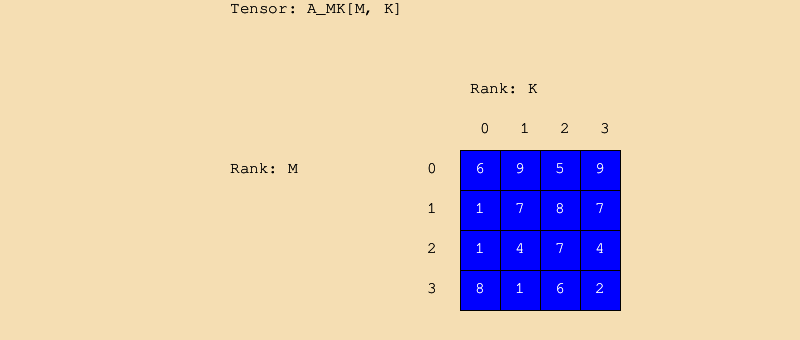

Input B


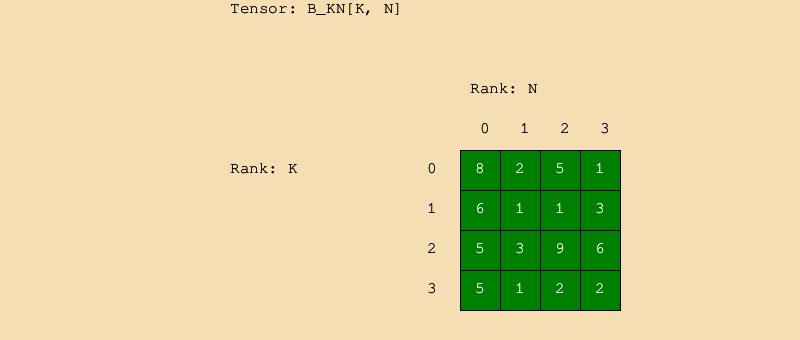

In [3]:
M = 4
M1 = M // M0
K = 4
K1 = K // K0
N = 4
N1 = N // N0

a_MK_raw = []
for m in range(M):
    a_MK_raw.append([random.randint(1, 9) for i in range(K)])
                 
b_KN_raw = []
for k in range(K):
    b_KN_raw.append([random.randint(1, 9) for i in range(N)])

a_MK = Tensor.fromUncompressed(["M", "K"], a_MK_raw)
b_KN = Tensor.fromUncompressed(["K", "N"], b_KN_raw)

a_MK.setName("A_MK").setColor("blue")
b_KN.setName("B_KN").setColor("green")

print("Input A")
displayTensor(a_MK)
                    
print("Input B")
displayTensor(b_KN)

z_verify = None

def create_z():
    """
    Create a fully populated z tensor
    """
    z = Tensor(rank_ids=["M", "N"], default='')
    z.setName("Z")
    z.setMutable(True)

    z_m = z.getRoot()
    #
    # Hack to fill in all the entries in z
    # This allows us to pretend the tensor is dense
    #
    n_fiber = Fiber(coords=range(N), initial=1)
    m_fiber = Fiber(coords=range(M), initial=1)

    for m, (z_n, _) in z_m << m_fiber:
        for n, (z_ref, _) in z_n << n_fiber:
            z_ref <<= 0
            
    return z

## Utility function for addressing

In [4]:
def getAddress(tensor, x, y):
    return (x*tensor.getShape()[1]+y)

## Matrix Multiply

We are visualizing matrix multiplication we examined in Part 1 Question 2. You will observe some cache statistics below.

Matrix Multiply
Output - before


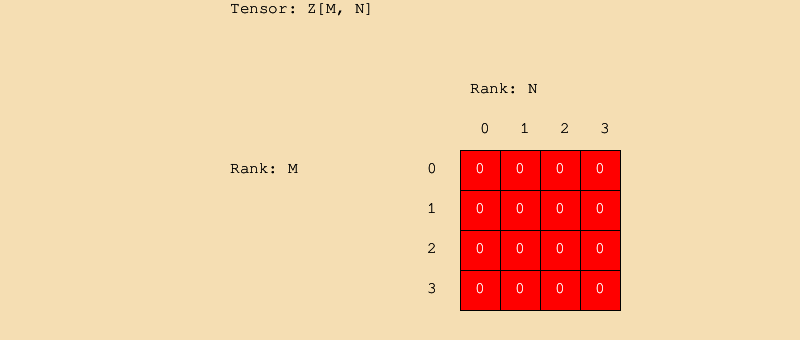

Output - after


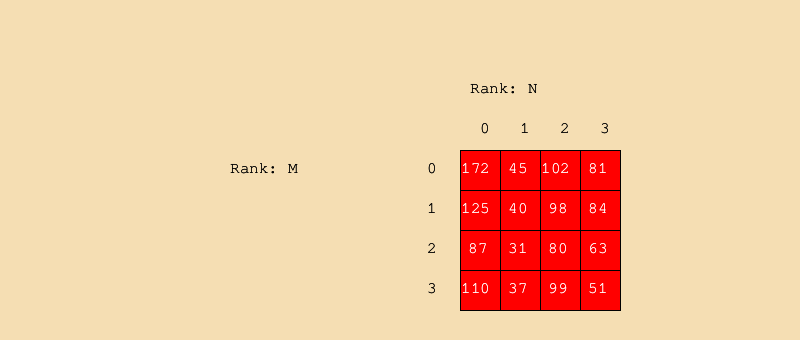

Create individual tensor images for each cycle: 0it [00:00, ?it/s]

Paste individual tensor images into frame for each cycle:   0%|          | 0/66 [00:00<?, ?it/s]

Render video frame for each cycle:   0%|          | 0/66 [00:00<?, ?it/s]

-------Cache A--------
Cache Statistics:
cache rd: 48
cache wr: 0
mem rd: 16
mem wr: 0
-------Cache B--------
Cache Statistics:
cache rd: 0
cache wr: 0
mem rd: 64
mem wr: 0
-------Cache C--------
Cache Statistics:
cache rd: 48
cache wr: 64
mem rd: 16
mem wr: 64


In [5]:
print("Matrix Multiply")

cache_a = Cache(log_size=3, words_per_line=1)
cache_b = Cache(log_size=3, words_per_line=1)
cache_c = Cache(log_size=3, words_per_line=1)

z_MN = create_z()

print("Output - before")
displayTensor(z_MN)

z = z_MN.getRoot()
a = a_MK.getRoot()
b = b_KN.getRoot()

canvas = createCanvas(a_MK, b_KN, z_MN)
for m in range(M):
    a_tile = [ (m, kt) for kt in range(K)]
    for n in range(K):
        logger(f"Processing Z({m},{n}) = {z[m][n]}")
        b_tile = [ (kt, n) for kt in range(K)]
        z_tile = (m, n)
        for k in range(N):
            logger(f"Processing A({m},{k}) = {a[m][k].payload}")
            logger(f"Processing B({k},{n}) = {b[k][n].payload}")
            
            cache_a.load(getAddress(a, m, k))
            cache_b.load(getAddress(b, k, n))
              
            cache_c.load(getAddress(z, m, n))
            z[m][n] += a[m][k] * b[k][n]
            addActivity(canvas, a_tile, b_tile, z_tile, worker="W")
            addFrame(canvas, (m,k), (k,n), (m,n))
        
            cache_c.store(getAddress(z, m, n))

print("Output - after")
displayTensor(z)

displayCanvas(canvas)

if z_verify is None:
    z_verify = deepcopy(z)

# Print cache statistics
print("-------Cache A--------")
cache_a.print_stats()
print("-------Cache B--------")
cache_b.print_stats()
print("-------Cache C--------")
cache_c.print_stats()

### Question 1

In [6]:
# PLEASE ANSWER ALL QUESTIONS WHILE USING THE PROVIDED INITIAL VALUES
answer(
    question='2.1',
    subquestion="Does the cache for tensor A have (1) compulsory, (2) capacity, and (3) conflict misses? Please write your answer (True/False in Python) in order as a list (e.g., [True, False, True]).",
    answer= [True, False, False], # Answer here
    required_type=[bool, bool, bool],
)
answer(
    question='2.1',
    subquestion="Does the cache for tensor B have (1) compulsory, (2) capacity, and (3) conflict misses? Please write your answer (True/False in Python) in order as a list (e.g., [True, False, True]).",
    answer= [True, True, True], # Answer here
    required_type=[bool, bool, bool],
)
answer(
    question='2.1',
    subquestion="Does the cache for tensor C have (1) compulsory, (2) capacity, and (3) conflict misses? Please write your answer (True/False in Python) in order as a list (e.g., [True, False, True]).",
    answer= [True, False, False], # Answer here
    required_type=[bool, bool, bool],
)

2.1: Does the cache for tensor A have (1) compulsory, (2) capacity, and (3) conflict misses? Please write your answer (True/False in Python) in order as a list (e.g., [True, False, True]).
	[True, False, False]
2.1: Does the cache for tensor B have (1) compulsory, (2) capacity, and (3) conflict misses? Please write your answer (True/False in Python) in order as a list (e.g., [True, False, True]).
	[True, True, True]
2.1: Does the cache for tensor C have (1) compulsory, (2) capacity, and (3) conflict misses? Please write your answer (True/False in Python) in order as a list (e.g., [True, False, True]).
	[True, False, False]


## Tiled Matrix Multiply

Here we are simulating a __tiled__ matrix multiply. Caches are the same as above. You do not need to code anything here.

In [ ]:
print("Matrix Multiply")

cache_a = Cache(log_size=3, words_per_line=1)
cache_b = Cache(log_size=3, words_per_line=1)
cache_c = Cache(log_size=3, words_per_line=1)

z_MN = create_z()

print("Output - before")
displayTensor(z_MN)

z = z_MN.getRoot()
a = a_MK.getRoot()
b = b_KN.getRoot()

canvas = createCanvas(a_MK, b_KN, z_MN)

for m1 in range(M1):
    for k1 in range(K1):
        for n1 in range(N1):
            a_tile = [ (m1*M0+mt, k1*K0+kt) for mt in range(M0) for kt in range(K0)]
            b_tile = [ (k1*K0+kt, n1*N0+nt) for kt in range(K0) for nt in range(N0)]

            for m0 in range(M0):
                for k0 in range(K0):
                    for n0 in range(N0):
                        m = m1*M0+m0
                        n = n1*N0+n0
                        k = k1*K0+k0
                        
                        cache_a.load(getAddress(a, m, k))
                        cache_b.load(getAddress(b, k, n))
                        cache_c.load(getAddress(z, m, n))
                        
                        z[m][n] += a[m][k] * b[k][n]

                        z_tile = (m, n)
                        
                        addActivity(canvas, a_tile, b_tile, z_tile, worker="W")
                        addFrame(canvas, (m,k), (k,n), (m,n))
                        
                        cache_c.store(getAddress(z, m, n))

print("Output - after")
displayTensor(z)

displayCanvas(canvas)

if z_verify is None:
    print("Result not verified")
else:
    assert z == z_verify
    
# Print cache statistics
print("-------Cache A--------")
cache_a.print_stats()
print("-------Cache B--------")
cache_b.print_stats()
print("-------Cache C--------")
cache_c.print_stats()

### Question 2

In [ ]:
# PLEASE ANSWER ALL QUESTIONS WHILE USING THE PROVIDED INITIAL VALUES
answer(
    question='2.2.1',
    subquestion="Does the cache for tensor A have (1) compulsory, (2) capacity, and (3) conflict misses? Please write your answer (True/False in Python) in order as a list (e.g., [True, False, True]).",
    answer= ['FILL ME', 'FILL ME', 'FILL ME'], # Answer here
    required_type=[bool, bool, bool],
)
answer(
    question='2.2.1',
    subquestion="Does the cache for tensor B have (1) compulsory, (2) capacity, and (3) conflict misses? Please write your answer (True/False in Python) in order as a list (e.g., [True, False, True]).",
    answer= ['FILL ME', 'FILL ME', 'FILL ME'], # Answer here
    required_type=[bool, bool, bool],
)
answer(
    question='2.2.1',
    subquestion="Does the cache for tensor C have (1) compulsory, (2) capacity, and (3) conflict misses? Please write your answer (True/False in Python) in order as a list (e.g., [True, False, True]).",
    answer= ['FILL ME', 'FILL ME', 'FILL ME'], # Answer here
    required_type=[bool, bool, bool],
)
answer(
    question='2.2.1',
    subquestion="Compared to the untiled matrix multiplication, which of 'compulsory', 'capacity', or 'conflict' misses does tiling reduce?",
    answer= 'FILL ME',
    required_type=('compulsory', 'capacity', 'conflict'),
)

To better understand how tiling results in fewer capacity misses, we analyze the *reuse distance* of each tensor. Here, we define reuse distance as *the number of unique tensor elements that are accessed between subsequent access of the same element, including the first access of that element*. For example, if the tensor A has the following accesses:
```
a[0][0], a[0][1], a[1][0], a[1][1], a[0][0], a[0][1], ...
```
Then, the element `a[0][0]` has reuse distance of 4. If the cache has capacity larger than 4 and there are no address conflicts, then the element `a[0][0]` is reused; otherwise, it is not reused, and we have a cache miss.

In [ ]:
# PLEASE ANSWER ALL QUESTIONS WHILE USING THE PROVIDED INITIAL VALUES
answer(
    question='2.2.2',
    subquestion="How many times is an element of tensor A accessed?",
    answer= 'FILL ME',
    required_type=Number,
)
answer(
    question='2.2.2',
    subquestion="What is the reuse distance of tensor A in the dataflow in QUESTION 1? Answer with an integer value.",
    answer= 'FILL ME',
    required_type=Number,
)
answer(
    question='2.2.2',
    subquestion="What is the maximum reuse distance of tensor B in the dataflow in QUESTION 1? Answer with an integer value.",
    answer= 'FILL ME',
    required_type=Number,
)

An element of a tensor may be accessed more than twice and the reuse distance between any two accesses may not be the same. This is the case with the tiled dataflow.

In [ ]:
# PLEASE ANSWER ALL QUESTIONS WHILE USING THE PROVIDED INITIAL VALUES
answer(
    question='2.2.3',
    subquestion="What is the reuse distance of tensor A in the dataflow in QUESTION 2? Answer as a list of [shorter reuse distance, longer reuse distance].",
    answer= ['FILL ME', 'FILL ME'], # Answer here
    required_type=[Number, Number],
)
answer(
    question='2.2.3',
    subquestion="What is the reuse distance of tensor B in the dataflow in QUESTION 2? Answer as a list of [shorter reuse distance, longer reuse distance].",
    answer= ['FILL ME', 'FILL ME'], # Answer here
    required_type=[Number, Number],
)

Here, we see that tiling involves a trade-off. The new chosen tiling reduces the reuse distance of (some) repeated accesses of tensor B elements. At the same time, (some) reuse distance of repeated accesses of tensor A elements have increased.

Because the increased reuse distance of tensor A is still within the capacity of `cache_a` and the shorter reuse distance of tensor B is within the capacity of `cache_b`, this tiling choice results in fewer misses overall.

## Important Takeaway
More data reuse overall (thus, fewer misses) can be achieved by using a carefully chosen tiling to trade-off the reuse distance of one tensor with another tensor.